# Notebook 3:  ARIMA Modeling (Bitcoin Log Returns)
**Goal**
- Fit ARIMA model on stationary log returns
- Forecast test period
- Evaluate model performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 1) Load Dataset

In [3]:
df = pd.read_csv("C:/Projects/05_bitcoin_forecasting/data/btc_cleaned.csv", header=[0,1], index_col=0, parse_dates=True)
df.columns = ["Close"]

# Recreate log returns
df["Log_Return"] = np.log(df["Close"] / df["Close"].shift(1))
df = df.dropna()

df.head()

,Close,Log_Return
Date,,
2021-02-20,56099.519531,0.003775
2021-02-21,57539.945312,0.025352
2021-02-22,54207.320312,-0.059663
2021-02-23,48824.425781,-0.104585
2021-02-24,49705.332031,0.017881


## 2) Train/Test Split

We use 80% training, 20% testing.

In [4]:
train_size = int(len(df) * 0.8)

train = df["Log_Return"][:train_size]
test = df["Log_Return"][train_size:]

print("Train size:", len(train))
print("Test size:", len(test))

Train size: 1460
Test size: 366


## 3) Fit ARIMA Model

We start simple with ARIMA(1,0,1).
Since log returns are already stationary, d = 0.

In [5]:
model = ARIMA(train, order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\shwey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\shwey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\shwey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Log_Return   No. Observations:                 1460
Model:                 ARIMA(1, 0, 1)   Log Likelihood                3001.454
Date:                Thu, 26 Feb 2026   AIC                          -5994.908
Time:                        16:55:17   BIC                          -5973.763
Sample:                    02-20-2021   HQIC                         -5987.020
                         - 02-18-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.454      0.650      -0.001       0.002
ar.L1         -0.4992      0.359     -1.390      0.165      -1.203       0.205
ma.L1          0.4574      0.368      1.243      0.2

## 4) Forecast

In [6]:
forecast = model_fit.forecast(steps=len(test))

forecast = pd.Series(forecast, index=test.index)

## 5) Evaluation

In [8]:
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)

print ("RMSE:" , rmse)
print ("MAE:" , mae )

RMSE: 0.024248113854958186
MAE: 0.016486120534024328


## 6) PLot Forecast Vs Actual

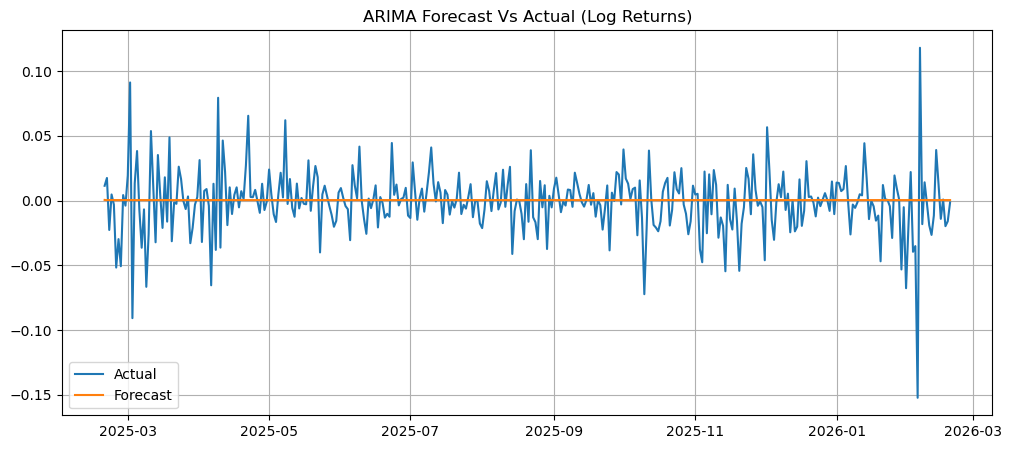

In [9]:
plt.figure(figsize=(12,5))
plt.plot(test, label="Actual")
plt.plot(forecast, label="Forecast")
plt.title("ARIMA Forecast Vs Actual (Log Returns)")
plt.legend()
plt.grid(True)
plt.show()

The ARIMA (1,0,1) model produces forecasts that remain close to zero, reflecting the weak autocorrelation in the log return series. Although the model achieves moderate error values (RMSE = 0.024, MAE = 0.016), it fails to capture large volatility spikes. This suggests limited short-term linear predictability in Bitcoin returns

## 5) Try multiple (p,d,q) 

In [10]:
import warnings
warnings.filterwarnings("ignore")

best_aic = float("inf")
best_order = None
best_model = None

results = []

for p in range(0, 4):
    for q in range(0, 4):
        order = (p, 0, q)
        try:
            model = ARIMA(train, order=order)
            fit = model.fit()
            aic = fit.aic
            
            # Forecast and RMSE
            fc = fit.forecast(steps=len(test))
            rmse = np.sqrt(mean_squared_error(test, fc))
            mae = mean_absolute_error(test, fc)
            
            results.append((order, aic, rmse, mae))
            
            if aic < best_aic:
                best_aic = aic
                best_order = order
                best_model = fit
        except:
            continue

results_df = pd.DataFrame(results, columns=["order", "AIC", "RMSE", "MAE"]).sort_values("AIC")
results_df.head(10)

,order,AIC,RMSE,MAE
4,"(1, 0, 0)",-5995.500419,0.024248,0.016486
0,"(0, 0, 0)",-5995.481238,0.024248,0.016486
1,"(0, 0, 1)",-5995.373453,0.024248,0.016486
8,"(2, 0, 0)",-5995.067105,0.024248,0.016487
2,"(0, 0, 2)",-5994.956832,0.024248,0.016487
5,"(1, 0, 1)",-5994.907593,0.024248,0.016486
9,"(2, 0, 1)",-5993.106971,0.024248,0.016487
12,"(3, 0, 0)",-5993.077625,0.024248,0.016487
6,"(1, 0, 2)",-5992.956005,0.024248,0.016487
3,"(0, 0, 3)",-5992.953003,0.024248,0.016487


## 6) Refit the best model

In [11]:
print("Best ARIMA order by AIC:", best_order)
print(best_model.summary())

best_forecast = best_model.forecast(steps=len(test))
best_forecast = pd.Series(best_forecast, index=test.index)

rmse_best = np.sqrt(mean_squared_error(test, best_forecast))
mae_best = mean_absolute_error(test, best_forecast)

print("Best RMSE:", rmse_best)
print("Best MAE:", mae_best)

Best ARIMA order by AIC: (1, 0, 0)
                               SARIMAX Results                                
Dep. Variable:             Log_Return   No. Observations:                 1460
Model:                 ARIMA(1, 0, 0)   Log Likelihood                3000.750
Date:                Thu, 26 Feb 2026   AIC                          -5995.500
Time:                        17:26:22   BIC                          -5979.642
Sample:                    02-20-2021   HQIC                         -5989.585
                         - 02-18-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.458      0.647      -0.001       0.002
ar.L1         -0.0372      0.021     -1.766      0.077      -0.078       0.004
sigma2         0.

## 7) Re-plot




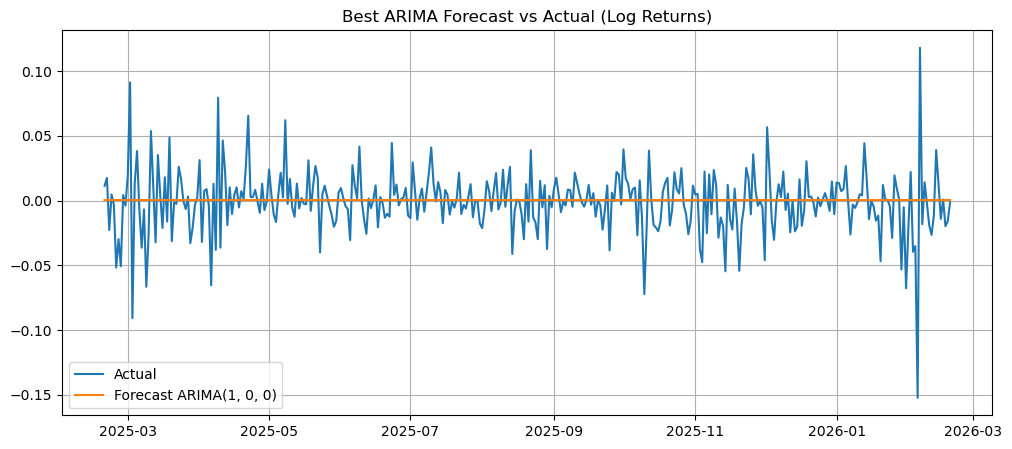

In [12]:
plt.figure(figsize=(12,5))
plt.plot(test, label="Actual")
plt.plot(best_forecast, label=f"Forecast ARIMA{best_order}")
plt.title("Best ARIMA Forecast vs Actual (Log Returns)")
plt.legend()
plt.grid(True)
plt.show()

## 8) Add a Baseline comparison

In [13]:
baseline = np.zeros(len(test))
rmse_base = np.sqrt(mean_squared_error(test, baseline))
mae_base = mean_absolute_error(test, baseline)

print("Baseline RMSE:", rmse_base)
print("Baseline MAE:", mae_base)

Baseline RMSE: 0.0242304506205845
Baseline MAE: 0.016479300666036156


### ARIMA Model Tuning Results
Although trying multiple ARIMA (p,d,q) models orders, I got nearly identical RMSE and MAE. The AIC differences were minimal, suggesting that the additional AR or MA terms do not significantly improve model performance. 
This indicates that Bitcoin log returns exhibit weak linear autocorrelation and behave similarly to a white noise process.
As a result, linear ARIMA models have limited ability to predict short-term return fluctuations.